In this notebook we fit linear filters predicting neural activity from sensory inputs.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from aux import Generic
from aux import make_extended_predictor_matrix, calc_r2
from data import random_chunk_split
from plot import set_font_size

import CONFIG as C

# Define function to fit linear filter

In [7]:
def fit_filter(trial, x_name, y_name, x_wdw, train, test):
    """
    Given a trial, fit a linear filter mapping an input (x_name) time-series to 
    an output (y_name) time series and return fit results.
    
    :param x_wdw: (t_start, t_end) relative to timepoint of prediction
    :param train: training mask (must have same size as trial.dl.t)
    :param test: test mask (must have same size as trial.dl.t)
    
    :return:
        FitResult object with attributes:
            trial_name
            
            x_name
            y_name
            
            x_wdw
            x_wdw_dsct
            
            train
            test
            
            t
            x
            y
            
            r2_train
            y_hat_train
            
            r2_test
            y_hat_test
            
            t_h
            h
    """
    t = getattr(trial.dl, 't')
    
    assert len(t) == len(train) == len(test)
    
    # munge data into arguments for LinearRegression.fit
    x = getattr(trial.dl, x_name)
    
    vs = {x_name: x}
    
    x_wdw_dsct = (int(round(x_wdw[0] / C.DT)), int(round(x_wdw[1] / C.DT)))
    wdws_dsct = {x_name: x_wdw_dsct}
    
    order = [x_name]
    
    x_xtd = make_extended_predictor_matrix(vs=vs, windows=wdws_dsct, order=order)
    y = getattr(trial.dl, y_name)
    
    # get valid mask
    valid = np.all(~np.isnan(x_xtd), axis=1) & (~np.isnan(y))
    
    # prepare result dict
    fit_result_dict = {
        'trial_name': trial.name,
        'x_name': x_name,
        'y_name': y_name,
        'x_wdw': x_wdw,
        'x_wdw_dsct': x_wdw_dsct,
        'train': train,
        'test': test,
        't': t,
        'x': x,
        'y': y,
        't_h': np.arange(*x_wdw_dsct) * C.DT,
    }
    
    # fit model if possible
    if np.sum(valid & train) > x_xtd.shape[1]:
        
        # fit model
        rgr = LinearRegression()
        rgr.fit(x_xtd[valid & train], y[valid & train])
        
        # make training predictions
        y_hat_train = np.nan * np.zeros(y.shape)
        y_hat_train[valid & train] = rgr.predict(x_xtd[valid & train])
        
        fit_result_dict['r2_train'] = calc_r2(y[valid & train], y_hat_train[valid & train])
        fit_result_dict['y_hat_train'] = y_hat_train
        
        # make test predictions
        if np.sum(valid & test) > 0:
            y_hat_test = np.nan * np.zeros(y.shape)
            y_hat_test[valid & test] = rgr.predict(x_xtd[valid & test])
            
            fit_result_dict['r2_test'] = calc_r2(y[valid & test], y_hat_test[valid & test])
            fit_result_dict['y_hat_test'] = y_hat_test
        
        else:
            print('No valid test data.')
            
            fit_result_dict['y_hat_test'] = np.nan * np.zeros(y.shape)
            fit_result_dict['r2_test'] = np.nan
            
        # store filter
        fit_result_dict['h'] = rgr.coef_
            
    else:
        print('Not enough data to fit model.')
        
        fit_result_dict['r2_train'] = np.nan
        fit_result_dict['y_hat_train'] = np.nan * np.zeros(y.shape)
        
        fit_result_dict['r2_test'] = np.nan
        fit_result_dict['y_hat_test'] = np.nan * np.zeros(y.shape)
        
        fit_result_dict['h'] = np.nan * np.ones(x_xtd.shape[1])
        
    return Generic(**fit_result_dict)

# Test filter-fitting function

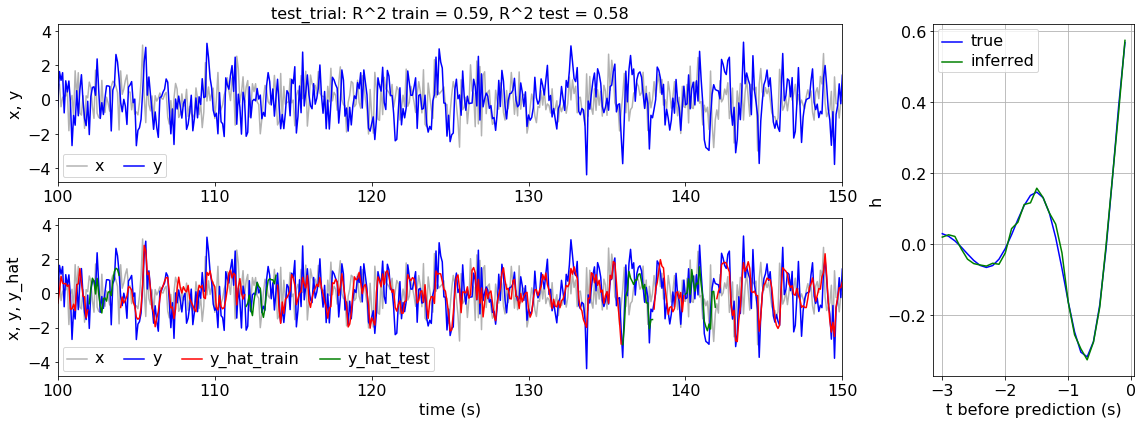

In [19]:
import pdb

def test_fit_filter(*t_lim):
    np.random.seed(0)
    
    # mock data
    t = np.arange(0, 300, C.DT)
    x = np.random.normal(0, 1, t.shape)
    
    t_h = np.arange(-3, 0, C.DT)
    h = np.exp(t_h/1) * np.cos(4 * t_h)
    h /= np.linalg.norm(h)
    
    y = np.convolve(x, np.concatenate([h, np.zeros(h.shape)])[::-1], mode='same') \
        + np.random.normal(0, .8, t.shape)
    
    # mock data loader
    dl = Generic(t=t, x=x, y=y)
    
    # mock trial
    trial = Generic(name='test_trial', dl=dl)
    
    # make train and test masks
    train, test = random_chunk_split(t, 0.75, 2)
    
    # fit function
    rslt = fit_filter(trial, 'x', 'y', (-3, 0), train, test)
    
    # plot true and found filters
    gs = gridspec.GridSpec(2, 4)
    
    fig = plt.figure(figsize=(16, 6), tight_layout=True)
    ax_0 = fig.add_subplot(gs[0, :3])
    ax_1 = fig.add_subplot(gs[1, :3], sharex=ax_0)
    ax_2 = fig.add_subplot(gs[:, 3])
    
    # plot x, y, y_hat_train, y_hat_test
    ax_0.plot(t, x, color='k', alpha=0.3)
    ax_0.plot(t, y, color='b')
    
    ax_0.set_ylabel('x, y')
    ax_0.set_title('{0}: R^2 train = {1:.2f}, R^2 test = {2:.2f}'.format(
        rslt.trial_name, rslt.r2_train, rslt.r2_test))
    
    ax_0.legend(['x', 'y'], ncol=2)
    
    ax_1.plot(t, x, color='k', alpha=0.3)
    ax_1.plot(t, y, color='b')
    ax_1.plot(t, rslt.y_hat_train, color='r')
    ax_1.plot(t, rslt.y_hat_test, color='g')
    
    ax_1.set_xlim(*t_lim)
    
    ax_1.set_xlabel('time (s)')
    ax_1.set_ylabel('x, y, y_hat')
    ax_1.legend(['x', 'y', 'y_hat_train', 'y_hat_test'], ncol=4)
    
    # plot filters
    ax_2.plot(t_h, h, color='b')
    ax_2.plot(t_h, rslt.h, color='g')
    
    ax_2.grid()
    
    ax_2.set_xlabel('t before prediction (s)')
    ax_2.set_ylabel('h')
    
    ax_2.legend(['true', 'inferred'])
    
    for ax in [ax_0, ax_1, ax_2]:
        set_font_size(ax, 16)
        
test_fit_filter(100, 150)

In [6]:
pdb.pm()

> /Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py(470)check_array()
-> context))
(Pdb) u
> /Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py(573)check_X_y()
-> ensure_min_features, warn_on_dtype, estimator)
(Pdb) u
> /Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/base.py(482)fit()
-> y_numeric=True, multi_output=True)
(Pdb) u
> <ipython-input-2-0dc5ee12944a>(76)fit_filter()
-> rgr.fit(x_xtd[valid & train], y[valid & train])
(Pdb) l
 71  	    # fit model if possible
 72  	    if np.sum(valid & train) > x_xtd.shape[1]:
 73  	
 74  	        # fit model
 75  	        rgr = LinearRegression()
 76  ->	        rgr.fit(x_xtd[valid & train], y[valid & train])
 77  	
 78  	        # make training predictions
 79  	        y_hat_train = np.nan * np.zeros(y.shape)
 80  	        y_hat_train[valid & train] = rgr.predict(x_xtd[valid & train])
 81  	
(Pdb) print(x)
[ 1.76405235  0.40015721  0.9787